In [14]:
# pip install scikit-learn matplotlib

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

## 1. Principal Component Analysis (PCA)

**Objective**: Find orthogonal directions (principal components) that maximize variance.

$$\text{PC}_1 = \arg\max_{\|w\|=1} \text{Var}(Xw) = \arg\max_{\|w\|=1} w^T \Sigma w$$

**Algorithm**:
1. **Standardize** the data (zero mean, unit variance)
2. Compute the **covariance matrix** $\Sigma = \frac{1}{n-1}X^TX$
3. Find **eigenvectors** of $\Sigma$ (these are the principal components)
4. **Project** data onto top $k$ eigenvectors

### PCA from Scratch

In [ ]:
def pca_scratch(X, n_components):
    """
    PCA from scratch using eigendecomposition.
    
    Parameters:
        X: array of shape (n_samples, n_features), assumed already centered
        n_components: number of components to keep
    
    Returns:
        X_projected: transformed data
        components: principal component directions
        explained_variance_ratio: variance explained by each component
    """
    # Step 1: Compute covariance matrix
    n_samples = X.shape[0]
    cov_matrix = (X.T @ X) / (n_samples - 1)
    
    # Step 2: Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort by eigenvalue (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 3: Select top k components
    components = eigenvectors[:, :n_components].T
    
    # Step 4: Project data
    X_projected = X @ components.T
    
    # Explained variance ratio
    explained_variance_ratio = eigenvalues[:n_components] / eigenvalues.sum()
    
    return X_projected, components, explained_variance_ratio

# 2. Example: Dimensionality Reduction (2D → 1D)

- In two dimensions, we can visualize exactly what PCA does. This builds intuition before applying PCA to high-dimensional data.

- We generate 200 observations in 2-dim $\mathbf{X}=(X_1, X_2)$ where the two dimensions are positively correlated.
The data forms an elongated ellipse — most variation lies along one diagonal direction.


- The PC1 direction of maximum variance (the long axis of the ellipse). Captures ~99% of variance.
- By keeping only PC1, we reduce from 2D to 1D while retaining most information.


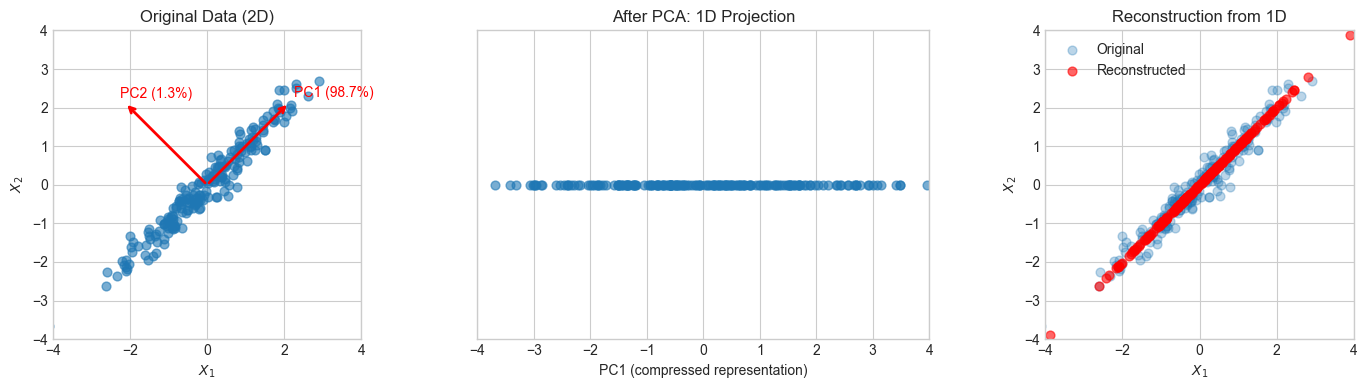

Original dimensions: 2
Compressed dimensions: 1
Variance retained: 98.7%


In [13]:
# Generate 2D data with correlation
np.random.seed(42)
n_samples = 200
X_corr = np.random.randn(n_samples, 2)
X_corr = X_corr @ np.array([[1, 0.8], [0.8, 1]])  # Add correlation

# Center the data
X_centered = X_corr - X_corr.mean(axis=0)

# Get both PC directions for visualization
_, all_components, all_var_ratio = pca_scratch(X_centered, n_components=2)

# Apply PCA - keep only 1 component (true dimensionality reduction!)
X_1d, components, var_ratio = pca_scratch(X_centered, n_components=1)

# Reconstruct back to 2D using only PC1
X_reconstructed = X_1d @ components  # Project back: (n, 1) @ (1, 2) -> (n, 2)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left: Original 2D data with both PC directions
axes[0].scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.6, s=40)
for i, (comp, var) in enumerate(zip(all_components, all_var_ratio)):
    axes[0].annotate('', xy=comp*3, xytext=[0, 0],
                     arrowprops=dict(arrowstyle='->', color='red', lw=2))
    axes[0].text(comp[0]*3.2, comp[1]*3.2, f'PC{i+1} ({var:.1%})', fontsize=10, color='red')
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('Original Data (2D)')
axes[0].set_aspect('equal')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)

# Middle: 1D projection (the compressed representation)
axes[1].scatter(X_1d, np.zeros_like(X_1d), alpha=0.6, s=40)
axes[1].set_xlabel('PC1 (compressed representation)')
axes[1].set_yticks([])
axes[1].set_title('After PCA: 1D Projection')
axes[1].set_xlim(-4, 4)

# Right: Reconstruction back to 2D
axes[2].scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.3, s=40, label='Original')
axes[2].scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6, s=40, c='red', label='Reconstructed')
axes[2].set_xlabel('$X_1$')
axes[2].set_ylabel('$X_2$')
axes[2].set_title('Reconstruction from 1D')
axes[2].set_aspect('equal')
axes[2].set_xlim(-4, 4)
axes[2].set_ylim(-4, 4)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Original dimensions: 2")
print(f"Compressed dimensions: 1")
print(f"Variance retained: {var_ratio[0]:.1%}")

# 3. Choosing the Number of Principal Components

In practice, the number of principal components is chosen based on explained variance.

- **Scree Plot**: Plot explained variance against the component index and select the point where marginal gains decline sharply (the elbow).

- **Cumulative Explained Variance**: Choose the smallest \( k \) such that cumulative explained variance exceeds a given threshold (e.g., 90\%).

### Example: Iris Dataset

The Iris dataset contains 150 observations with four features.
Applying PCA yields:

- **Scree plot:**  
  PC1 explains ~73\% and PC2 ~23\% of total variance, with a clear elbow at \( k=2 \).
- **Cumulative variance:**  
  The first two components explain ~96\% of total variance.

**Conclusion.**  
Two principal components provide an adequate low-dimensional representation of the data.

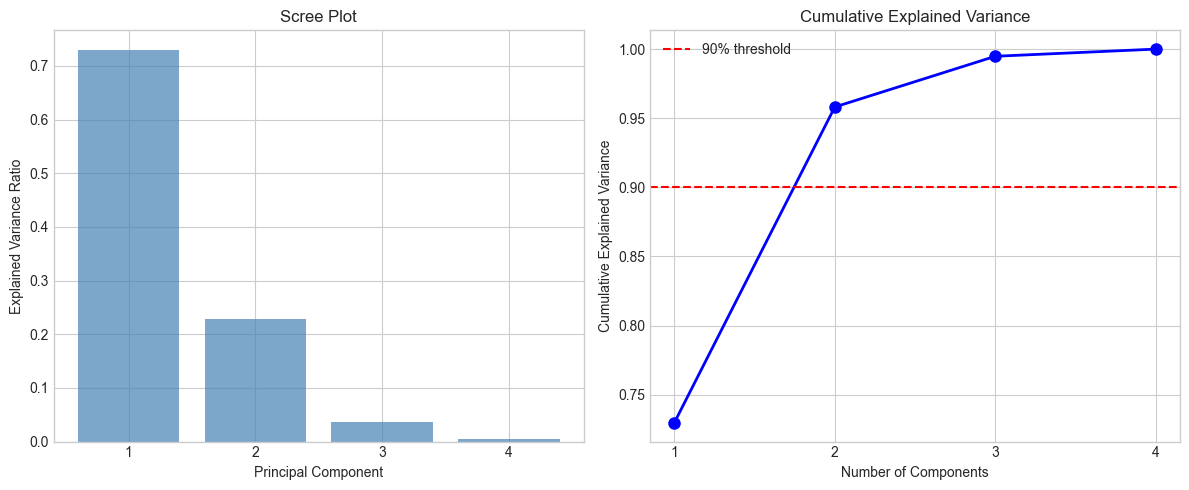

Explained variance ratio: [0.73  0.229 0.037 0.005]
Cumulative: [0.73  0.958 0.995 1.   ]


In [10]:
# Load Iris dataset (4 features)
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Standardize
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Apply sklearn PCA (keep all components)
pca_full = PCA()
pca_full.fit(X_iris_scaled)

# Scree plot and cumulative variance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scree plot
axes[0].bar(range(1, 5), pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].set_xticks(range(1, 5))

# Cumulative variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, 5), cumvar, 'bo-', linewidth=2, markersize=8)
axes[1].axhline(y=0.9, color='red', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xticks(range(1, 5))
axes[1].legend()

plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca_full.explained_variance_ratio_.round(3))
print("Cumulative:", cumvar.round(3))